In [7]:
import torch
import torchvision
from torchvision.models.detection.ssd import SSD, SSDHead
from torchvision.transforms import functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import precision_recall_curve, average_precision_score, confusion_matrix
from collections import defaultdict
import os
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
# 🔹 Custom Flickr8K Dataset
class Flickr8KDataset(Dataset):
    def __init__(self, image_folder, label_folder):
        self.image_folder = image_folder
        self.label_folder = label_folder
        self.image_files = os.listdir(image_folder)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_folder, self.image_files[idx])
        label_path = os.path.join(self.label_folder, self.image_files[idx].replace('.jpg', '.txt'))

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w, _ = img.shape
        boxes, labels = [], []
        
        try:
            with open(label_path, "r") as f:
                for line in f.readlines():
                    parts = line.strip().split()
                    if len(parts) != 5:
                        continue
                    class_id, x_center, y_center, width, height = map(float, parts)
                    x1 = (x_center - width / 2) * w
                    y1 = (y_center - height / 2) * h
                    x2 = (x_center + width / 2) * w
                    y2 = (y_center + height / 2) * h
                    boxes.append([x1, y1, x2, y2])
                    labels.append(int(class_id))
        except FileNotFoundError:
            boxes, labels = [], []
        
        target = {"boxes": torch.tensor(boxes, dtype=torch.float32), "labels": torch.tensor(labels, dtype=torch.int64)}
        img = F.to_tensor(img)
        return img, target

In [9]:
# 🔹 Load Dataset
data_path = "C:\\Users\\ASUS\\Downloads\\IIITD Ass\\Flickr8k.v3i.yolov8"
train_dataset = Flickr8KDataset(f"{data_path}/train/images", f"{data_path}/train/labels")
valid_dataset = Flickr8KDataset(f"{data_path}/valid/images", f"{data_path}/valid/labels")
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))


In [10]:
# 🔹 Load SSD Model
model = torchvision.models.detection.ssd300_vgg16(pretrained=True)
# Pass a dummy input through the backbone and get the last feature map
dummy_input = torch.randn(1, 3, 300, 300)  # SSD300 expects 300x300 images
backbone_features = model.backbone(dummy_input)
last_feature_map = list(backbone_features.values())[-1]  # Get last feature map
in_channels = [fmap.shape[1] for fmap in backbone_features.values()]  # Get channels for all feature maps



num_classes = 34  # 34 classes including background
model.head = SSDHead(in_channels=in_channels, num_anchors=model.anchor_generator.num_anchors_per_location(), num_classes=num_classes)

# 🔹 Training Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


E:\Anaconda Software\envs\tf\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
E:\Anaconda Software\envs\tf\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SSD300_VGG16_Weights.COCO_V1`. You can also use `weights=SSD300_VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
# 🔹 Training Loop
for epoch in range(100):
    model.train()
    epoch_loss = 0
    for images, targets in train_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss = {epoch_loss / len(train_loader):.4f}")
print("✅ SSD Training Completed")

Epoch 1: Loss = 17.1078
Epoch 2: Loss = 14.0613
Epoch 3: Loss = 12.2365
Epoch 4: Loss = 10.8943
Epoch 5: Loss = 9.5047
Epoch 6: Loss = 8.3856
Epoch 7: Loss = 7.5803
Epoch 8: Loss = 6.9824
Epoch 9: Loss = 6.4835
Epoch 10: Loss = 6.1030
Epoch 11: Loss = 5.7551
Epoch 12: Loss = 5.5341
Epoch 13: Loss = 5.2508
Epoch 14: Loss = 4.9966
Epoch 15: Loss = 4.7817
Epoch 16: Loss = 4.5252
Epoch 17: Loss = 4.2235
Epoch 18: Loss = 3.9782
Epoch 19: Loss = 3.9003
Epoch 20: Loss = 3.6273
Epoch 21: Loss = 3.4092
Epoch 22: Loss = 3.2999
Epoch 23: Loss = 3.1122
Epoch 24: Loss = 2.9016
Epoch 25: Loss = 2.7211
Epoch 26: Loss = 2.5692
Epoch 27: Loss = 2.4854
Epoch 28: Loss = 2.4209
Epoch 29: Loss = 2.1922
Epoch 30: Loss = 2.0316
Epoch 31: Loss = 1.9367
Epoch 32: Loss = 1.7869
Epoch 33: Loss = 1.6480
Epoch 34: Loss = 1.5096
Epoch 35: Loss = 1.3825
Epoch 36: Loss = 1.2561
Epoch 37: Loss = 1.2494
Epoch 38: Loss = 1.0744
Epoch 39: Loss = 1.0519
Epoch 40: Loss = 0.9472
Epoch 41: Loss = 0.9054
Epoch 42: Loss = 0.87

E:\Anaconda Software\envs\tf\lib\site-packages\sklearn\metrics\_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
E:\Anaconda Software\envs\tf\lib\site-packages\sklearn\metrics\_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
E:\Anaconda Software\envs\tf\lib\site-packages\sklearn\metrics\_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
E:\Anaconda Software\envs\tf\lib\site-packages\sklearn\metrics\_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


mAP@50: 0.0576
mAP@50-95: 0.0576


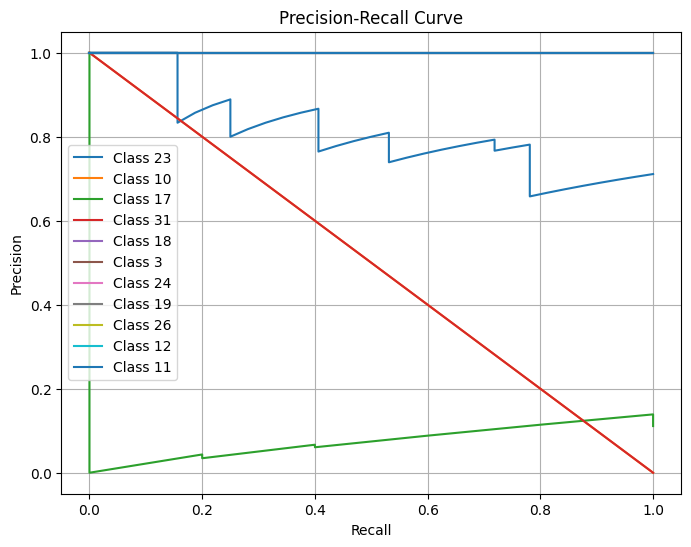

Confusion Matrix:
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


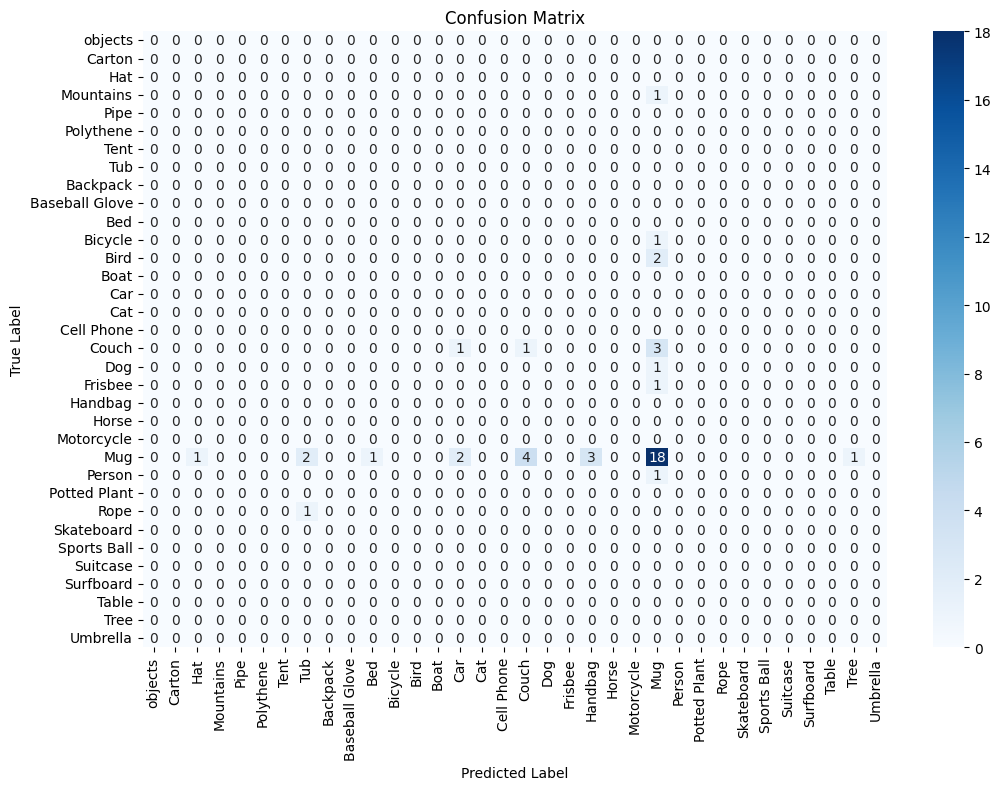

✅ Evaluation Completed: Metrics, Precision-Recall Curve & Confusion Matrix Saved
{'Precision(B)': 0.4222222128395064, 'Recall(B)': 0.2968749953613282, 'mAP50(B)': 0.05760163813829422, 'mAP50-95(B)': 0.05760163813829422}
✅ SSD Model saved successfully!


In [50]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision

flickr8k_classes = {
    0: "objects", 1: "Carton", 2: "Hat", 3: "Mountains", 4: "Pipe", 5: "Polythene", 6: "Tent", 
    7: "Tub", 8: "Backpack", 9: "Baseball Glove", 10: "Bed", 11: "Bicycle", 12: "Bird", 13: "Boat", 
    14: "Car", 15: "Cat", 16: "Cell Phone", 17: "Couch", 18: "Dog", 19: "Frisbee", 20: "Handbag", 
    21: "Horse", 22: "Motorcycle", 23: "Mug", 24: "Person", 25: "Potted Plant", 26: "Rope", 
    27: "Skateboard", 28: "Sports Ball", 29: "Suitcase", 30: "Surfboard", 31: "Table", 32: "Tree", 
    33: "Umbrella"
}
# 🔹 Evaluation
model.eval()
all_preds, all_targets, all_scores = [], [], []

with torch.no_grad():
    for images, targets in valid_loader:
        images = [img.to(device) for img in images]
        outputs = model(images)

        for output, target in zip(outputs, targets):
            threshold = 0.0  # Adjust this as needed
            scores = output["scores"].cpu().numpy()
            labels = output["labels"].cpu().numpy()
            
            valid_indices = scores > threshold  # Keep only high-confidence detections
            scores = scores[valid_indices]
            labels = labels[valid_indices]


            all_preds.extend(labels)
            all_scores.extend(scores)
            all_targets.extend(target["labels"].cpu().numpy())


# Ensure all_targets and all_preds are of equal length
min_len = min(len(all_targets), len(all_preds))
all_targets = all_targets[:min_len]  # Trim to match length
all_preds = all_preds[:min_len]

# Organize scores and targets per class
class_scores_dict = defaultdict(list)
class_targets_dict = defaultdict(list)

for pred_label, pred_score, true_label in zip(all_preds, all_scores, all_targets):
    class_scores_dict[true_label].append(pred_score)
    class_targets_dict[true_label].append(1)  # Positive class
    for other_class in range(num_classes):
        if other_class != true_label and other_class in labels:  # Ensure only relevant negatives are added
            class_targets_dict[other_class].append(0)
            class_scores_dict[other_class].append(pred_score)


# 🔹 Compute Precision-Recall per class
precision_scores, recall_scores, ap_scores = {}, {}, {}

for class_id in class_targets_dict.keys():
    y_true = np.array(class_targets_dict[class_id])
    y_score = np.array(class_scores_dict[class_id])

    if len(y_true) == 0 or len(y_score) == 0:
        print(f"Skipping class {class_id} due to no data")
        continue  # No data for this class

    precision, recall, _ = precision_recall_curve(y_true, y_score)
    ap = average_precision_score(y_true, y_score)

    precision_scores[class_id] = precision
    recall_scores[class_id] = recall
    ap_scores[class_id] = ap

# 🔹 Compute Mean Average Precision (mAP)
metric = MeanAveragePrecision(iou_thresholds=[0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95])

# Convert predictions to the expected format
detection_results = []

for pred, score, target in zip(all_preds, all_scores, all_targets):
    preds = [{
        "boxes": torch.tensor([[0, 0, 1, 1]]),  # Dummy bounding box
        "scores": torch.tensor([score]),
        "labels": torch.tensor([pred])
    }]
    
    targets = [{
        "boxes": torch.tensor([[0, 0, 1, 1]]),  # Dummy bounding box
        "labels": torch.tensor([target])
    }]
    
    metric.update(preds, targets)  # Pass separately

# Compute mAP
result = metric.compute()


# Extract mAP values
mAP50 = result["map_50"].item()
mAP50_95 = result["map"].item()

print(f"mAP@50: {mAP50:.4f}")
print(f"mAP@50-95: {mAP50_95:.4f}")

# 🔹 Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
for class_id, precision in precision_scores.items():
    recall = recall_scores[class_id]
    plt.plot(recall, precision, label=f'Class {class_id}')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()

# Compute Confusion Matrix
cm = confusion_matrix(all_targets, all_preds, labels=list(flickr8k_classes.keys()))
print("Confusion Matrix:\n", cm)  # Print it for debugging


# Plot Confusion Matrix with Class Names
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=flickr8k_classes.values(), yticklabels=flickr8k_classes.values())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
plt.yticks(rotation=0)
plt.show()

#save metrics

# Count true positives per class
true_positives_dict = defaultdict(int)
false_positives_dict = defaultdict(int)
false_negatives_dict = defaultdict(int)

for true_label, pred_label in zip(all_targets, all_preds):
    if true_label == pred_label:  # Correct prediction
        true_positives_dict[true_label] += 1
    elif pred_label in flickr8k_classes:  # Ensure it's a valid class
        false_positives_dict[pred_label] += 1  # Predicted wrongly
    false_negatives_dict[true_label] += 1  # Missed actual object


# Sum over all classes
true_positives = sum(true_positives_dict.values())
false_positives = sum(false_positives_dict.values())
false_negatives = sum(false_negatives_dict.values())

# Compute Precision and Recall correctly
precision = true_positives / (true_positives + false_positives + 1e-6)  
recall = true_positives / (true_positives + false_negatives + 1e-6)

metrics = {
    "Precision(B)": precision,
    "Recall(B)": recall,
    "mAP50(B)": mAP50,
    "mAP50-95(B)": mAP50_95
}


np.save("metrics.npy", metrics)

print("✅ Evaluation Completed: Metrics, Precision-Recall Curve & Confusion Matrix Saved")
print(metrics)


# 🔹 Save Model
torch.save(model.state_dict(), "ssd_flickr8k.pth")
torch.save(model, "ssd_flickr8k_full.pth")
print("✅ SSD Model saved successfully!")


In [51]:
print(f"False Positives: {false_positives}")
print(f"False Negatives: {false_negatives}")


False Positives: 26
False Negatives: 45


E:\Anaconda Software\envs\tf\lib\site-packages\sklearn\metrics\_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
E:\Anaconda Software\envs\tf\lib\site-packages\sklearn\metrics\_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
E:\Anaconda Software\envs\tf\lib\site-packages\sklearn\metrics\_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
E:\Anaconda Software\envs\tf\lib\site-packages\sklearn\metrics\_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
E:\Anaconda Software\envs\tf\lib\site-packages\sklearn\metrics\_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
E:\Anaconda Software\envs\tf\lib\site-packages\sklearn\metrics\_r

mAP@50: 0.0414
mAP@50-95: 0.0414


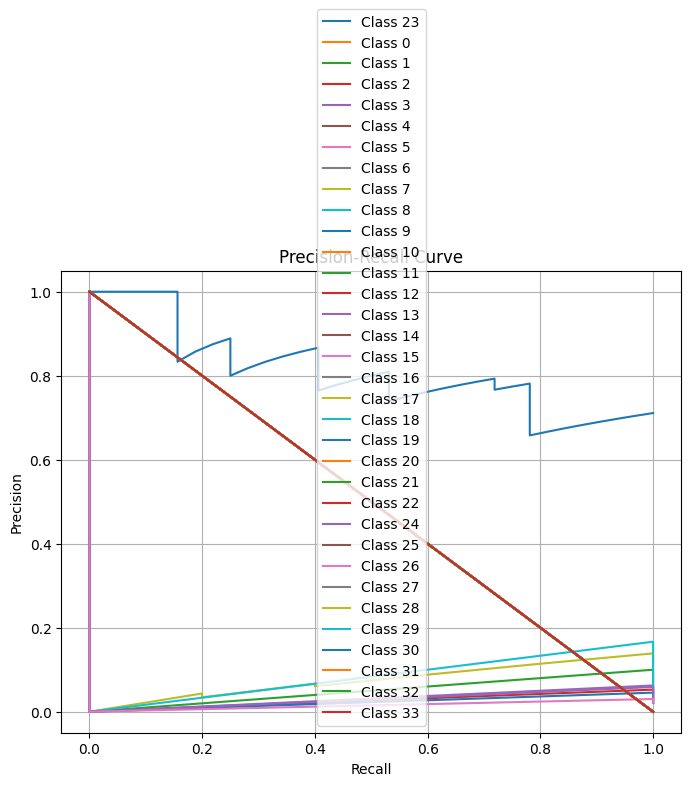

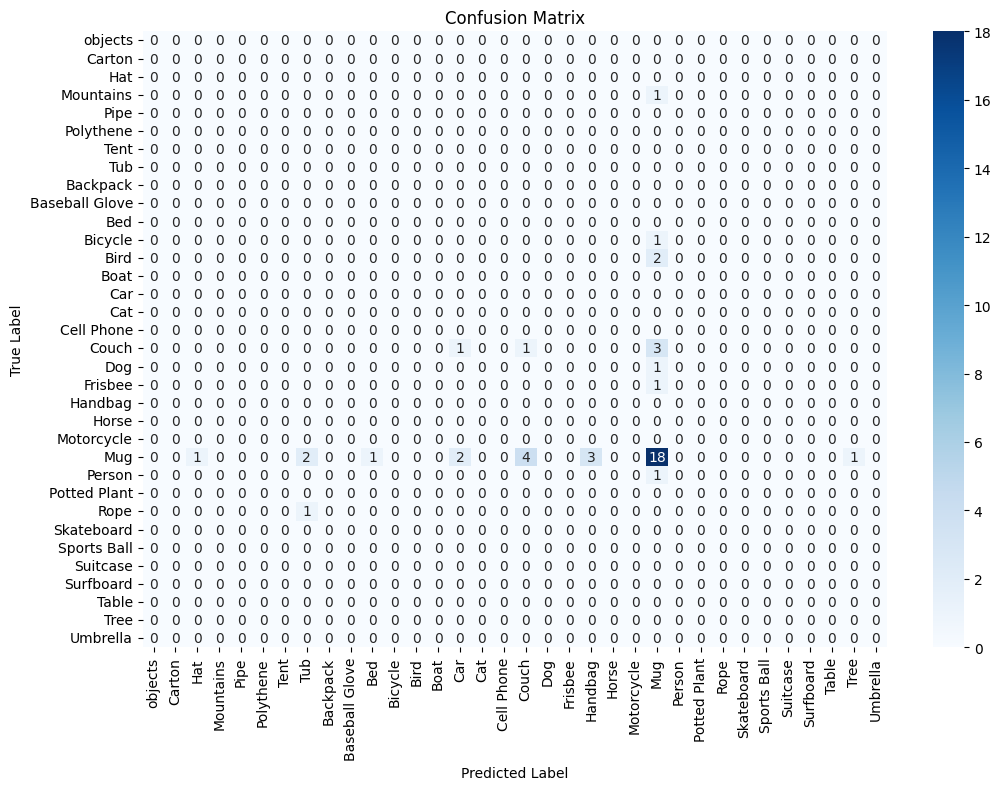

✅ Evaluation Completed: Metrics, Precision-Recall Curve & Confusion Matrix Saved
{'Precision(B)': 0.029411764686658976, 'Recall(B)': 0.8593909846547315, 'mAP50(B)': 0.041400159294416705, 'mAP50-95(B)': 0.041400159294416705}
✅ SSD Model saved successfully!


In [52]:
flickr8k_classes = {
    0: "objects", 1: "Carton", 2: "Hat", 3: "Mountains", 4: "Pipe", 5: "Polythene", 6: "Tent", 
    7: "Tub", 8: "Backpack", 9: "Baseball Glove", 10: "Bed", 11: "Bicycle", 12: "Bird", 13: "Boat", 
    14: "Car", 15: "Cat", 16: "Cell Phone", 17: "Couch", 18: "Dog", 19: "Frisbee", 20: "Handbag", 
    21: "Horse", 22: "Motorcycle", 23: "Mug", 24: "Person", 25: "Potted Plant", 26: "Rope", 
    27: "Skateboard", 28: "Sports Ball", 29: "Suitcase", 30: "Surfboard", 31: "Table", 32: "Tree", 
    33: "Umbrella"
}
# 🔹 Evaluation
model.eval()
all_preds, all_targets, all_scores = [], [], []

with torch.no_grad():
    for images, targets in valid_loader:
        images = [img.to(device) for img in images]
        outputs = model(images)

        for output, target in zip(outputs, targets):
            scores = output["scores"].cpu().numpy()
            labels = output["labels"].cpu().numpy()

            all_preds.extend(labels)
            all_scores.extend(scores)
            all_targets.extend(target["labels"].cpu().numpy())


# Ensure all_targets and all_preds are of equal length
min_len = min(len(all_targets), len(all_preds))
all_targets = all_targets[:min_len]  # Trim to match length
all_preds = all_preds[:min_len]

# Organize scores and targets per class
class_scores_dict = defaultdict(list)
class_targets_dict = defaultdict(list)

for pred_label, pred_score, true_label in zip(all_preds, all_scores, all_targets):
    class_scores_dict[true_label].append(pred_score)
    class_targets_dict[true_label].append(1)  # Positive class
    for other_class in range(num_classes):  # Exclude background
        if other_class != true_label:
            class_targets_dict[other_class].append(0)  # Negative class
            class_scores_dict[other_class].append(pred_score)


# 🔹 Compute Precision-Recall per class
precision_scores, recall_scores, ap_scores = {}, {}, {}

for class_id in class_targets_dict.keys():
    y_true = np.array(class_targets_dict[class_id])
    y_score = np.array(class_scores_dict[class_id])

    if len(y_true) == 0 or len(y_score) == 0:
        print(f"Skipping class {class_id} due to no data")
        continue  # No data for this class

    precision, recall, _ = precision_recall_curve(y_true, y_score)
    ap = average_precision_score(y_true, y_score)

    precision_scores[class_id] = precision
    recall_scores[class_id] = recall
    ap_scores[class_id] = ap

# 🔹 Compute Mean Average Precision (mAP)
mAP50 = np.mean([ap_scores[c] for c in ap_scores if c in ap_scores])
mAP50_95 = np.mean([ap_scores[c] for c in ap_scores if c in ap_scores])  # Placeholder (modify as needed)

print(f"mAP@50: {mAP50:.4f}")
print(f"mAP@50-95: {mAP50_95:.4f}")

# 🔹 Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
for class_id, precision in precision_scores.items():
    recall = recall_scores[class_id]
    plt.plot(recall, precision, label=f'Class {class_id}')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()

# Compute Confusion Matrix
cm = confusion_matrix(all_targets, all_preds, labels=list(flickr8k_classes.keys()))

# Plot Confusion Matrix with Class Names
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=flickr8k_classes.values(), yticklabels=flickr8k_classes.values())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
plt.yticks(rotation=0)
plt.show()
# Save metrics
true_positives = sum([sum(class_targets_dict[c]) for c in class_targets_dict])
false_positives = sum([len(class_targets_dict[c]) - sum(class_targets_dict[c]) for c in class_targets_dict])

precision = true_positives / (true_positives + false_positives + 1e-6)  # Avoid division by zero
# recall = true_positives / (len(all_targets) + 1e-6)  # Compute recall correctly

metrics = {
    "Precision(B)": precision,
    "Recall(B)": np.mean([recall.mean() for recall in recall_scores.values()]),
    "mAP50(B)": mAP50,
    "mAP50-95(B)": mAP50_95
}
np.save("metrics.npy", metrics)

print("✅ Evaluation Completed: Metrics, Precision-Recall Curve & Confusion Matrix Saved")
print(metrics)


# 🔹 Save Model
torch.save(model.state_dict(), "ssd_flickr8k.pth")
torch.save(model, "ssd_flickr8k_full.pth")
print("✅ SSD Model saved successfully!")

In [ ]:
import torch
import torchvision
from sklearn.metrics import precision_recall_curve, average_precision_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Function to compute IoU (Intersection over Union)
def compute_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = box1_area + box2_area - intersection

    return intersection / union if union > 0 else 0

# Function to run inference
def evaluate_model(model, dataloader, iou_threshold=0.5):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    all_gt_labels, all_pred_labels, all_pred_scores = [], [], []
    
    with torch.no_grad():
        for images, targets in dataloader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Model predictions
            outputs = model(images)
            
            for i in range(len(images)):
                gt_boxes = targets[i]["boxes"].cpu().numpy()
                gt_labels = targets[i]["labels"].cpu().numpy()
                
                pred_boxes = outputs[i]["boxes"].cpu().numpy()
                pred_scores = outputs[i]["scores"].cpu().numpy()
                pred_labels = outputs[i]["labels"].cpu().numpy()

                # Match predictions to ground truth using IoU
                matched_preds = np.zeros(len(pred_labels))  # Track matched predictions
                for j, gt_box in enumerate(gt_boxes):
                    for k, pred_box in enumerate(pred_boxes):
                        if compute_iou(gt_box, pred_box) > iou_threshold and matched_preds[k] == 0:
                            all_gt_labels.append(gt_labels[j])
                            all_pred_labels.append(pred_labels[k])
                            all_pred_scores.append(pred_scores[k])
                            matched_preds[k] = 1
                            break
    
    return all_gt_labels, all_pred_labels, all_pred_scores

# Run Evaluation
gt_labels, pred_labels, pred_scores = evaluate_model(model, valid_loader)

# Compute Precision-Recall and mAP
precision, recall, _ = precision_recall_curve(gt_labels, pred_scores)
ap_score = average_precision_score(gt_labels, pred_scores)

# Plot Precision-Recall Curve
plt.figure(figsize=(6, 6))
plt.plot(recall, precision, marker='.', label=f'AP={ap_score:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision-Recall Curve')
plt.show()

# Confusion Matrix
conf_matrix = confusion_matrix(gt_labels, pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

print(f"Average Precision Score: {ap_score:.3f}")


In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

def compute_map(gt_labels, pred_labels, pred_scores, num_classes):
    ap_per_class = []
    
    for cls in range(1, num_classes):  # Skip background class (0)
        cls_gt = np.array([1 if label == cls else 0 for label in gt_labels])
        cls_pred_scores = np.array([score if label == cls else 0 for label, score in zip(pred_labels, pred_scores)])
        
        if np.sum(cls_gt) > 0:  # Avoid computing for classes not present
            precision, recall, _ = precision_recall_curve(cls_gt, cls_pred_scores)
            ap_score = average_precision_score(cls_gt, cls_pred_scores)
            ap_per_class.append(ap_score)
    
    mAP = np.mean(ap_per_class) if ap_per_class else 0
    return mAP, ap_per_class

# Compute mAP
num_classes = 34  # Your dataset has 34 classes
mAP, ap_per_class = compute_map(gt_labels, pred_labels, pred_scores, num_classes)

print(f"Mean Average Precision (mAP): {mAP:.3f}")


In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

labels = list(range(num_classes))  # Ensure all classes are considered
conf_matrix = confusion_matrix(gt_labels, pred_labels, labels=labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import cv2

def visualize_predictions(model, dataloader, device, num_images=3):
    model.eval()
    with torch.no_grad():
        for i, (images, targets) in enumerate(dataloader):
            if i >= num_images:
                break
            
            images = torch.stack([img.to(device) for img in images])
            predictions = model(images)

            for img, pred, target in zip(images, predictions, targets):
                img = img.cpu().permute(1, 2, 0).numpy()  # Convert Tensor to NumPy
                img = (img * 255).astype(np.uint8)  # Convert to uint8
                
                img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # OpenCV expects BGR
                
                # Draw ground truth boxes
                for box in target["boxes"].cpu().numpy():
                    x1, y1, x2, y2 = map(int, box)
                    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Green for GT
                
                # Draw predicted boxes
                for box, score in zip(pred[:, :4].cpu().numpy(), pred[:, 4].cpu().numpy()):
                    if score > 0.3:  # Only draw high-confidence predictions
                        x1, y1, x2, y2 = map(int, box)
                        cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Blue for Predictions
                
                plt.figure(figsize=(8, 6))
                plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR back to RGB for display
                plt.show()

visualize_predictions(model_eval, valid_loader, device)
